In [283]:
# Aux
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Model stuff
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

In [284]:
synth_gauss = {
    'n': 8000,                             # n_train -> 2500
    'd': [10, 50, 250, 500, 2000, 4000],   # data dimensions
    'sigma2': 1,                           # data variance
    'frac_important_features': 0.1,        # fraction of relevant features
    'sigma2_eps': 0.01,                    # label noise
    'corr': 0.0,                           # correlation between features
    'fit_sgd': False,                      # whether linear model should be fitted with sgd
    'n_shadow_models': 300,                # number of shadow models to train for LRT test versions
    'frac': 0.85,                          # fraction of samples used for resampling scheme within shadow model train pipeline
    'epsd': 1e-45,                         # constant to ensure stable loss evaluations
    'weighting': 'global'                  # whether global variance or 1/n_shadow_models should be used for variance
}

**DATA GENERATING PROCESS**

Denote by $\gamma$ the class threshold. 

Denote by $q_{\mathbf{x}_{\alpha}}$ the $100 \times \alpha$-th quantile of the vector $\mathbf{x}$.

Measurement error:
$$ \varepsilon \sim \mathcal{N}(0, \sigma^2_{\varepsilon}) $$
Design matrix: $$ \mathbf{X} \sim \mathcal{N}(\mu_d, \Sigma_d) $$
True coefficient vectors:
$$ \beta_0 \sim U[-1,1]^d$$
$$ \beta = \beta_0 \odot \mathbb{I}_d(|\beta_0| > q_{|\beta_{\alpha}|})$$
$$ \beta = \frac{\beta}{||\beta||_2} $$
Labels:
$$ score =  X \beta + \varepsilon $$
$$ p = \frac{1}{1+\exp(-score)} $$
$$ y =  \mathbb{I}\big( p  > \gamma \big) $$

Signal-to-noise ratio: $$ \frac{||\beta||_2}{\sigma^2_{\varepsilon}} = \frac{1}{\sigma^2_{\varepsilon}}$$ 
We fix the true weight vector to unit length to make sure that we keep a constant signal-to-noise ratio despite an increase in the feature dimension.


**CLASSIFIER**

For now we will train logistic regression classifiers without regulariziation

**DISTANCE using INPUT SPACE COUNTERFACTUAL ACTIONS**

- Target score in logit space: $s$
- Estimated weight of linear model: $\mathbf{w}$. Note that this is a **funtion of the training data**.
- Logit score: $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} = \log \frac{P(y=1|x)}{1-P(y=1|x)} $
- $\ell_2$ distance to target logit score: $\mathbf{\delta}_x = \frac{s-f(\mathbf{x})}{||\mathbf{w}||_2^2} \mathbf{w}$

- When the decision boundary threshold is set to $\xi=0  \Leftarrow \Rightarrow \gamma=0.5$ and $s=0$, then the above distance formula boils down to the standard formula that measures the 'distance to the decision boundary'
- **Note that the only factor that differs across train and test instances is $f(\mathbf{x})$**

**DISTANCE using LATENT SPACE COUNTERFACTUAL ACTIONS**

- We solve: $$\delta_z = argmin_{\delta_z'} \bigg( s-f\big(g(\mathbf{z}+\delta_z')\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$ for the case when: 
  - $f$: logit score from logistic regression classifier
  - $g$: decoder obtained through principal component analysis (PCA); for PCA, the encoder is the inverse of $g$
  
 In this case we can still obtain a closed-form solution, and let's see what insights we can learn from this. Note that the corresponding counterfactual in input space is given by:
 $$  \mathbf{x}_{\text{CF}} = g(\mathbf{z}+\delta_z) \text{ where } \mathbf{z} = g^{-1}(\mathbf{x})  $$
 
To be more concrete, we will assume the folling data generating process:
\begin{align*}
    \mathbf{x} &= g(\mathbf{z}) + \mathbf{r}_x \\
        &= W \mathbf{z} + \mathbf{r}_x. \\
\end{align*}
This two things:
- we use $k \leq d$ dimensions to construct our latent space; only the $k$ latent dimensions are used to for counterfactual search.
-  If $k = d$, then the reconstruction error will be $\mathbf{r}_x=\mathbf{0}$.

Now, we have everything in place to solve the above objective:

$$ \delta_z = argmin_{\delta_z'} \bigg( s-f\big(g(\mathbf{z}+\delta_z') + \mathbf{r}_x\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( s- \theta^\top \big(W \mathbf{z}+\delta_z' + \mathbf{r}_x\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( s- \theta^\top \mathbf{x} - \theta^\top W\delta_z' \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( m - \theta^\top W \delta_z' \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$

This problem is solved by:
$$ \delta_z = \frac{m}{\lambda + ||\tilde{\theta}||_2^2} \tilde{\theta} ~~ \text{where} ~~ m=s-\theta^\top \mathbf{x}, \tilde{\theta} = \theta^\top W$$

Finally, the action measured in input space is given by (for $\lambda \to 0$):
$$ \delta_x = W \delta_z  = W  \frac{s - f(\mathbf{x})}{||\tilde{\theta}||_2^2} \tilde{\theta} $$.

Note that $W$ and $\tilde{\theta}$ are constant across training and test points. So, again, **the only factor that differs across train and test instances is $f(\mathbf{x})$.**


In [285]:
def gen_lin_data(d:int, synth_gauss: dict):
    
    '''
    This method generates data from the data generating process described above. 
    ---------------------------------------------------------------------------
        Input: data dimension (int), snyth gauss (dictionary)
        Output: X, Y (np.arrays); training set size (int)
    '''
    
    n = synth_gauss['n']
    n_train = int(n/4)
    print(f'Number of training samples: {n_train}')

    n_train_half = int(2*int(n/2))
    sigma2 = synth_gauss['sigma2']
    frac_important_features = synth_gauss['frac_important_features']
    d_relevant = int(np.floor(d * frac_important_features))
    mu = np.zeros(d)
    Sigma2 = np.eye(d) * sigma2
    Sigma2 = np.ones((d, d)) * synth_gauss['corr'] + np.eye(d) * sigma2


    ### true parameter vector ###
    beta0 = np.zeros(d)
    beta = np.random.random(d) * 2 - 1                            # Coefficient randomly chosen from [-1,1]^d 
    quantile = np.quantile(np.abs(beta), 1 - frac_important_features)
    indeces = np.where(np.abs(beta) >= quantile)[0]               # Determine indeces of relevant coefficients
    
    beta0[0:d_relevant] = beta[indeces]
    beta1 = beta0 / np.linalg.norm(beta0, ord=2)                  # Normalize to have unit vector 1

    ### error variance parameters & distribution of errors ###
    sigma2_eps = synth_gauss['sigma2_eps']
    sigma_eps = np.sqrt(sigma2_eps)
    eps = np.random.normal(0, sigma_eps, n)                       # Parameterzied in terms of sigma (not sigma2)

    ### data generation ###
    X = np.random.multivariate_normal(mu, Sigma2, n)              # Generate & standardize data
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    score = X @ beta1 + eps                                       # Generate labels
    prob = 1/(1+np.exp(-score))
    Y_disc = (prob > 0.5) * 1
    
    return X, Y_disc, n_train

In [286]:
def vanilla_distances(score_train, score_test, w_train):
    '''
    This method takes the logit scores (as defined above) and the data weighs
    and computes standard ell_2 distances to logit target score. 
    ---------------------------------------------------------------------------
        Input: f (np.array), w (np.array)
        Output: distances (np.arrays)
    '''
    n_train = score_train.shape[0]
        
    train_deltas =  - score_train.reshape(-1,1) / np.linalg.norm(w_train, ord=2)**2 * np.tile(w_train, (n_train, 1))
    test_deltas = - score_test.reshape(-1,1) / np.linalg.norm(w_train, ord=2)**2 * np.tile(w_train, (n_train, 1))

    train_dist = np.linalg.norm(train_deltas, ord=2, axis=1)
    test_dist = np.linalg.norm(test_deltas, ord=2, axis=1)
    
    return train_dist, test_dist

In [287]:
def latent_distances(score_train, score_test, w_train, k=10, s=0):
    '''
    This method takes the logit scores (as defined above) and the data weighs
    and computes standard ell_2 distances to logit target score. 
    ---------------------------------------------------------------------------
        Input: f (np.array), w (np.array)
        Output: distances (np.arrays)
    '''
    n_train = score_train.shape[0]
    n_test = score_test.shape[0]
    
    ### Do PCA
    cov = (X_train.T @ X_train) / (X_train.shape[0] - 1)
    eig_values, eig_vectors = np.linalg.eig(cov)
    idx = np.argsort(eig_values, axis=0)[::-1]
    sorted_eig_vectors = eig_vectors[:, idx]
    W = sorted_eig_vectors[:, :k]
    
    ### Compute latent codes & reconstructions
    # Z_train = np.dot(X_train, W)
    # Xhat_train = np.dot(Z_train, W.T)
    # Z_test = np.dot(X_test, W)
    # Xhat_test = np.dot(Z_test, W.T)
    
    ### Compute distances
    ry_train = s - score_train
    ry_test = s - score_test
    w_tilde = W.T @ w_train
    delta_z_train = (ry_train.reshape(-1,1) / np.linalg.norm(w_tilde, ord=2)**2) * np.tile(w_tilde, (n_train, 1))
    train_deltas = delta_z_train @ W.T
    delta_z_test = (ry_test.reshape(-1,1) / np.linalg.norm(w_tilde, ord=2)**2) * np.tile(w_tilde, (n_test, 1))
    test_deltas = delta_z_test @ W.T
    train_dist = np.linalg.norm(train_deltas, ord=2, axis=1)
    test_dist = np.linalg.norm(test_deltas, ord=2, axis=1)
    
    return train_dist, test_dist

In [288]:
def _get_stable_logit_loss(label, 
                           prediction, 
                           eps=1e-45):
    if label == 1:
        stable_logit_loss = np.log(prediction + eps) - np.log((1-prediction) + eps)
    else:
        stable_logit_loss = np.log((1 - prediction) + eps) - np.log(prediction + eps)
    return stable_logit_loss

In [289]:
def compute_lambda_loss(stable_losses: np.array,
                        shadow_losses: np.array,
                        global_var: float,
                        global_variance=True,
                        eps=1e-45):
        '''
        Note that: logit_loss is the converted model confidence.
        The larger the target model’s confidence (i.e., stable loss) is compared to \mu_out
        (i.e., mean_shadow_losses), the higher the likelihood that the query sample is a member:
        
        Likelihood that stable loss is part of train: 1 - P(Mean Shadow models (RV) \leq stable loss):
        
        Note that we compute the following here:
        P(Mean Shadow models (RV) \leq stable loss) = \Phi( (Mean Shadow model - stable loss) / std(Mean Shadow models) )
        
        Thus, later on we have to adjust -> pos_label=0 in 'compute curve method'.
        
        # TODO:
        SAME LOGIC IS TRUE FOR THE METHODS BELOW: TWO METHODS BELOW ARE NOW JUST COPIES
        -> GET RID OF THEM
        '''
        number_shadow_models = shadow_losses.shape[1]
        mean_all_shadow_losses = np.mean(shadow_losses, axis=1)
        var_all_shadow_losses = np.var(shadow_losses, axis=1, ddof=1)
        if global_variance:
            var = global_var
        else:
            var = var_all_shadow_losses + eps
        cap_lambda = norm.cdf(x=mean_all_shadow_losses, loc=stable_losses, scale=np.sqrt(var))
        
        return cap_lambda

In [290]:
def compute_lambda_predictions(predictions: np.array,
                               shadow_predictions: np.array,
                               global_var: float,
                               global_variance=True,
                               eps=1e-45):

        number_shadow_models = shadow_predictions.shape[1]
        mean_all_shadow_predictions = np.mean(shadow_predictions, axis=1)
        var_all_shadow_predictions = np.var(shadow_predictions, axis=1, ddof=1)
            
        '''
        Note that: logit_loss is the converted model confidence.
        The larger the target model’s confidence (i.e., logit loss) is compared to µout
        (i.e., mean_shadow_losses), the higher the likelihood that the query sample is a member.
        '''
        if global_variance:
            var = global_var
        else:
            var = var_all_shadow_predictions + eps
        cap_lambda = norm.cdf(x=mean_all_shadow_predictions, loc=predictions, scale=np.sqrt(var))
        
        return cap_lambda

In [291]:
def compute_lambda_distances(distances: np.array,
                             shadow_distances: np.array,
                             global_var: float,
                             global_variance=True,
                             eps=1e-45):

        number_shadow_models = shadow_distances.shape[1]
        mean_all_shadow_distances = np.mean(shadow_distances, axis=1)
        var_all_shadow_distances = np.var(shadow_distances, axis=1, ddof=1)
            
        '''
        Note that: logit_loss is the converted model confidence.
        The larger the target model’s confidence (i.e., logit loss) is compared to µout
        (i.e., mean_shadow_losses), the higher the likelihood that the query sample is a member.
        '''
        if global_variance:
            var = global_var
        else:
            var = var_all_shadow_distances + eps
        cap_lambda = norm.cdf(x=mean_all_shadow_distances, loc=distances, scale=np.sqrt(var))
        
        return cap_lambda

In [292]:
def compute_shadowpredictions(X_train, X_test, X_shadow, Y_shadow, n_shadow_models=20, frac=0.60, eps=1e-45):
    '''
    This method computes log probabilities for training and test points w.r.t. the shadow models.
    '''
    # Preallocate
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    predictions_train = np.zeros((n_train, n_shadow_models))
    predictions_test = np.zeros((n_test, n_shadow_models))
    # Compute shadow predictions
    for i in range(n_shadow_models):
        ind_X_prime = np.random.choice(a=np.shape(X_shadow)[0], size=int(np.shape(X_shadow)[0] * frac), replace=False)
        X_prime_shadow = X_shadow[ind_X_prime]
        Y_prime_shadow = Y_shadow[ind_X_prime]
        model = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500).fit(X_prime_shadow, Y_prime_shadow)
        # Compute absolute value of logit scores
        predictions_train[:,i] = np.abs(np.log(model.predict_proba(X_train)[:,1] + epsd) - np.log(model.predict_proba(X_train)[:,0] + epsd))
        predictions_test[:,i] = np.abs(np.log(model.predict_proba(X_test)[:,1] + epsd) - np.log(model.predict_proba(X_test)[:,0] + epsd))
    return predictions_train, predictions_test

In [293]:
def compute_shadowlosses(X_train, Y_train, X_test, Y_test, X_shadow, Y_shadow, n_shadow_models=20, frac=0.60):
    '''
    This method computes stable losses for training and test points w.r.t. the shadow models.
    '''
    # preallocate
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    losses_train = np.zeros((n_train, n_shadow_models))
    losses_test = np.zeros((n_test, n_shadow_models))
    # compute shadow losses
    for i in range(n_shadow_models):
        ind_X_prime = np.random.choice(a=np.shape(X_shadow)[0], size=int(np.shape(X_shadow)[0] * frac), replace=False)
        X_prime_shadow = X_shadow[ind_X_prime]
        Y_prime_shadow = Y_shadow[ind_X_prime]
        model = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500).fit(X_prime_shadow, Y_prime_shadow)
        y_pred_train1 = model.predict_proba(X_train)[:,1]
        y_pred_test1 = model.predict_proba(X_test)[:,1]
        # preallocate
        stable_train_loss = np.zeros(y_pred_train1.shape[0])
        stable_test_loss = np.zeros(y_pred_test1.shape[0])
        for j in range(y_pred_train1.shape[0]):
            stable_train_loss[j] = _get_stable_logit_loss(Y_train[j], y_pred_train1[j])
            stable_test_loss[j] = _get_stable_logit_loss(Y_test[j], y_pred_test1[j]) 
        losses_train[:,i] = stable_train_loss
        losses_test[:,i] = stable_test_loss
    return losses_train, losses_test

In [294]:
def compute_shadowdistances(X_train, X_test, X_shadow, Y_shadow, n_shadow_models=20, frac=0.60, epsd=1e-45):
    
    '''
    This method computes ell_2 distances to the decision boundary 
    for training and test points w.r.t. the shadow models.
    '''
    # Preallocate
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    distances_train = np.zeros((n_train, n_shadow_models))
    distances_test = np.zeros((n_test, n_shadow_models))
    # Compute distances: here we use close-form solution since the underlying model is linear
    for i in range(n_shadow_models):
        ind_X_prime = np.random.choice(a=np.shape(X_shadow)[0], size=int(np.shape(X_shadow)[0] * frac), replace=False)
        X_prime_shadow = X_shadow[ind_X_prime]
        Y_prime_shadow = Y_shadow[ind_X_prime]
        model = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500).fit(X_prime_shadow, Y_prime_shadow)
        f_train = np.log(model.predict_proba(X_train)[:,1] + epsd) - np.log(model.predict_proba(X_train)[:,0] + epsd)
        w_train = model.coef_[0]
        f_test = np.log(model.predict_proba(X_test)[:,1] + epsd) - np.log(model.predict_proba(X_test)[:,0] + epsd)
        w_test = w_train[0]
        train_dist, test_dist = vanilla_distances(f_train, f_test, w_train)
        distances_train[:,i] = train_dist
        distances_test[:,i] = test_dist
    return distances_train, distances_test

In [295]:
epsd = synth_gauss['epsd']

scores = {
    'dists_train': [],              # DISTANCES
    'dists_test': [],
    'dists_latent_train': [],
    'dists_latent_test': [],
    'dists_lrt_train_local': [],
    'dists_lrt_test_local': [],
    'dists_lrt_train_global': [],
    'dists_lrt_test_global': [],
    'dists_train_quantile':[], 
    'dists_test_quantile':[],
    'losses_train': [],             # LOSSES
    'losses_test': [],
    'stable_losses_train': [],
    'stable_losses_test': [],
    'losses_lrt_train_local': [],
    'losses_lrt_test_local': [],
    'losses_lrt_train_global': [],
    'losses_lrt_test_global': [],
    'preds_train': [],              # PREDICTIONS
    'preds_test': [],
    'preds_lrt_train_local': [],
    'preds_lrt_test_local': [], 
    'preds_lrt_train_global': [],
    'preds_lrt_test_global': [] 
}

for i in synth_gauss['d']:
    
    ######################
    ### GENERATE DATA ###
    #####################
    print(f'Computing for dimension: {i}')
    
    X, Y_disc, n_train = gen_lin_data(d=i, synth_gauss=synth_gauss)
    
    # split data
    X, X_prime, Y, Y_prime = train_test_split(X.astype(float), 
                                              Y_disc.astype(float), 
                                              test_size=0.5,
                                              random_state=10)

    Y_train = Y[0:n_train]
    Y_test = Y[n_train::]
    X_train = X[0:n_train, :]
    X_test = X[n_train::, :]
    n_test = X_test.shape[0]
    
    ######################
    ###    FIT MODEL   ###
    ######################
    
    if synth_gauss['fit_sgd']:
        clf = SGDClassifier(loss='log', penalty='none', fit_intercept=True, max_iter=1500, tol=1e-6)
        clf.fit(X_train, Y_train)
    else:
        clf = LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500)
        clf.fit(X_train, Y_train)
        
    print('training set accuracy:', clf.score(X_train, Y_train))
    print('test set accuracy:', clf.score(X_test, Y_test))
    
    
    ####################
    ## COMPUTE LOSSES ##
    ####################
    
    y_pred_train1 = clf.predict_proba(X_train)[:,1]
    y_pred_train0 = clf.predict_proba(X_train)[:,0]
    
    y_pred_test1 = clf.predict_proba(X_test)[:,1]
    y_pred_test0 = clf.predict_proba(X_test)[:,0]
    
    ### vanilla losses
    train_loss = Y_train * np.log(y_pred_train1 + epsd) + (1-Y_train) * np.log(y_pred_train0 + epsd)
    test_loss = Y_test * np.log(y_pred_test1 + epsd) + (1-Y_test) * np.log(y_pred_test0 + epsd)
    
    scores['losses_train'].append(train_loss)
    scores['losses_test'].append(test_loss)
    
    ### stable losses
    stable_train_loss = np.zeros(y_pred_train1.shape[0])
    stable_test_loss = np.zeros(y_pred_test1.shape[0])
    for i in range(y_pred_train1.shape[0]):
        stable_train_loss[i] = _get_stable_logit_loss(Y_train[i], y_pred_train1[i])
        stable_test_loss[i] = _get_stable_logit_loss(Y_test[i], y_pred_test1[i])
    
    scores['stable_losses_train'].append(stable_train_loss)
    scores['stable_losses_test'].append(stable_test_loss)
    
    ### LRT losses
    shadow_losses_train, shadow_losses_test = compute_shadowlosses(X_train, Y_train,
                                                                   X_test, Y_test,
                                                                   X_prime, Y_prime, 
                                                                   n_shadow_models=synth_gauss['n_shadow_models'],
                                                                   frac=synth_gauss['frac'])
    # GLOBAL VAR
    vars_global_losses = np.var(np.r_[shadow_losses_train, shadow_losses_test], axis=1)
    if synth_gauss['weighting'] == 'equal':
        var_global_loss = 1
    else: 
        var_global_loss = np.mean(vars_global_losses)
    loss_lrt_train = compute_lambda_loss(stable_train_loss,
                                         shadow_losses_train,
                                         var_global_loss,
                                         global_variance=True)
    
    loss_lrt_test = compute_lambda_loss(stable_test_loss,
                                        shadow_losses_test,
                                        var_global_loss,
                                        global_variance=True)
    
    scores['losses_lrt_train_global'].append(loss_lrt_train)
    scores['losses_lrt_test_global'].append(loss_lrt_test)
    
    # LOCAL VAR
    loss_lrt_train = compute_lambda_loss(stable_train_loss,
                                         shadow_losses_train,
                                         var_global_loss,
                                         global_variance=False)
    
    loss_lrt_test = compute_lambda_loss(stable_test_loss,
                                        shadow_losses_test,
                                        var_global_loss,
                                        global_variance=False)
    
    scores['losses_lrt_train_local'].append(loss_lrt_train)
    scores['losses_lrt_test_local'].append(loss_lrt_test)
    
    #####################
    #COMPUTE PREDICTIONS#
    #####################
    
    ### predictions
    scores['preds_train'].append(np.log(clf.predict_proba(X_train)[:,1] + epsd) - np.log(clf.predict_proba(X_train)[:,0] + epsd))
    scores['preds_test'].append(np.log(clf.predict_proba(X_test)[:,1] + epsd) - np.log(clf.predict_proba(X_test)[:,0] + epsd))

    ### LRT predictions
    shadow_preds_train, shadow_preds_test = compute_shadowpredictions(X_train, X_test, 
                                                                      X_prime, Y_prime, 
                                                                      n_shadow_models=synth_gauss['n_shadow_models'],
                                                                      frac=synth_gauss['frac'])
    
    # GLOBAL VAR
    # use absolute values of logits as scores
    vars_global_preds = np.var(np.r_[shadow_preds_train, shadow_preds_test], axis=1)
    if synth_gauss['weighting'] == 'equal':
        var_global_preds = 1
    else:
        var_global_preds = np.mean(vars_global_preds)
    
    preds_lrt_score_train = compute_lambda_predictions(np.abs(np.log(y_pred_train1 + epsd) - np.log(y_pred_train0 + epsd)),
                                                       shadow_preds_train,
                                                       var_global_preds,
                                                       global_variance=True)
    
    preds_lrt_score_test = compute_lambda_predictions(np.abs(np.log(y_pred_test1 + epsd) - np.log(y_pred_test0 + epsd)),
                                                      shadow_preds_test,
                                                      var_global_preds,
                                                      global_variance=True)
    
    scores['preds_lrt_train_global'].append(preds_lrt_score_train) 
    scores['preds_lrt_test_global'].append(preds_lrt_score_test)    
    
    # LOCAL VAR
    preds_lrt_score_train = compute_lambda_predictions(np.abs(np.log(y_pred_train1 + epsd) - np.log(y_pred_train0 + epsd)),
                                                       shadow_preds_train,
                                                       var_global_preds,
                                                       global_variance=False)
    
    preds_lrt_score_test = compute_lambda_predictions(np.abs(np.log(y_pred_test1 + epsd) - np.log(y_pred_test0 + epsd)),
                                                      shadow_preds_test,
                                                      var_global_preds,
                                                      global_variance=False)
    
    scores['preds_lrt_train_local'].append(preds_lrt_score_train) 
    scores['preds_lrt_test_local'].append(preds_lrt_score_test)
    
    #####################
    # COMPUTE DISTANCES #
    #####################
    '''
            # here we use closed-form solutions for \ell_2 distance to boundary since the unerlying model is linear #
    '''    
    ### vanilla distances

    f_train = np.log(clf.predict_proba(X_train)[:,1] + epsd) - np.log(clf.predict_proba(X_train)[:,0] + epsd)
    w_train = clf.coef_[0]
    f_test = np.log(clf.predict_proba(X_test)[:,1] + epsd) - np.log(clf.predict_proba(X_test)[:,0] + epsd)
    w_test = w_train[0]
    train_dist, test_dist = vanilla_distances(f_train, f_test, w_train)
    train_dist_latent, test_dist_latent = latent_distances(f_train, f_test, w_train, k=5, s=0)
    
    scores['dists_train'].append(train_dist)
    scores['dists_test'].append(test_dist)
    scores['dists_latent_train'].append(train_dist_latent)
    scores['dists_latent_test'].append(test_dist_latent)
    
    ### LRT distances
    shadow_dists_train, shadow_dists_test = compute_shadowdistances(X_train, X_test, 
                                                                    X_prime, Y_prime, 
                                                                    n_shadow_models=synth_gauss['n_shadow_models'],
                                                                    frac=synth_gauss['frac'])
    
    # GLOBAL VAR
    vars_global_dists = np.var(np.r_[shadow_preds_train, shadow_preds_test], axis=1)
    if synth_gauss['weighting'] == 'equal':
        var_global_dists = 1
    else:
        var_global_dists = np.mean(vars_global_preds)
    
    dists_lrt_score_train = compute_lambda_predictions(train_dist,
                                                       shadow_dists_train,
                                                       var_global_dists,
                                                       global_variance=True)
    
    dists_lrt_score_test = compute_lambda_predictions(test_dist,
                                                      shadow_dists_test,
                                                      var_global_dists,
                                                      global_variance=True)
    
    scores['dists_lrt_train_global'].append(dists_lrt_score_train) 
    scores['dists_lrt_test_global'].append(dists_lrt_score_test) 
    
    # LOCAL VAR 
    dists_lrt_score_train = compute_lambda_predictions(train_dist,
                                                       shadow_dists_train,
                                                       var_global_dists,
                                                       global_variance=False)
    
    dists_lrt_score_test = compute_lambda_predictions(test_dist,
                                                      shadow_dists_test,
                                                      var_global_dists,
                                                      global_variance=False)
    
    scores['dists_lrt_train_local'].append(dists_lrt_score_train) 
    scores['dists_lrt_test_local'].append(dists_lrt_score_test)  
    
    '''
    ### quantile distances
    
    # STEP 1: GET DISTANCES
    f_test_prime = np.log(clf.predict_proba(X_prime)[:,1] + epsd) - np.log(clf.predict_proba(X_prime)[:,0] + epsd)
    prime_dist, _ = vanilla_distances(f_test_prime, f_test_prime, w_train)
    
    # STEP 2: GET QUANTILES
    qr = QuantileRegressor(quantile=0.95, alpha=0, solver="highs")
    clf_qr = qr.fit(X_prime, prime_dist)    
    
    nf_quantile_train = clf_qr.predict(X_train)
    nf_quantile_test = clf_qr.predict(X_test)
        
    measure_train = train_dist - nf_quantile_train
    measure_test = test_dist - nf_quantile_test
    
    scores['dists_train_quantile'].append(measure_train)
    scores['dists_test_quantile'].append(measure_test)
    '''

Computing for dimension: 10
Number of training samples: 2000
training set accuracy: 0.973
test set accuracy: 0.9655
Computing for dimension: 50
Number of training samples: 2000
training set accuracy: 0.969
test set accuracy: 0.955
Computing for dimension: 250
Number of training samples: 2000
training set accuracy: 1.0
test set accuracy: 0.9225
Computing for dimension: 500
Number of training samples: 2000
training set accuracy: 1.0
test set accuracy: 0.891
Computing for dimension: 2000
Number of training samples: 2000
training set accuracy: 1.0
test set accuracy: 0.7505
Computing for dimension: 4000
Number of training samples: 2000
training set accuracy: 1.0
test set accuracy: 0.6605


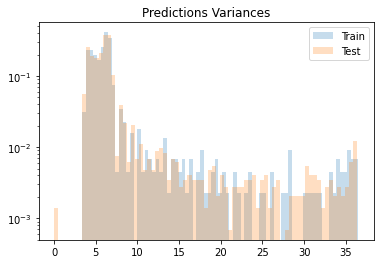

In [296]:
plt.title('Predictions Variances')
plt.hist(np.sqrt(vars_global_preds[0:1000]),bins=75, alpha=0.25, label='Train', density=True)
plt.hist(np.sqrt(vars_global_preds[1000::]),bins=75, alpha=0.25, label='Test', density=True)
plt.yscale('log')
plt.legend()

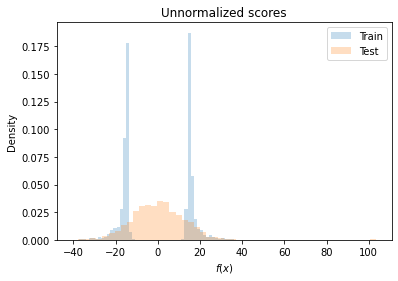

In [297]:
plt.title('Unnormalized scores')
plt.hist(f_train, bins=50, alpha=0.25, label='Train', density=True)
plt.hist(f_test, bins=50, alpha=0.25, label='Test', density=True)
plt.xlabel('$f(x)$')
plt.ylabel('Density')
plt.legend()

# Attack Overview

Below we plot results for a variety of different attacks:
- Simple Loss attack (Yeom et al (2018)) -> Threshold on the loss
- One sided LRT loss attack (Carlini et al (2021)) -> Train shadow models & adjust the loss statistic

Our proposed attacks are:
- Counterfactual distance attack
- Counterfactual distance LRT attack
- **New**: Counterfactual distance + quantile adjustment

The following attack is based on the above observation that the model becomes overconfident on training points (see histograms above). This is also the underlying mechanism for why the distance attack works.

- **New**: Prediction score (i.e., $ \log \frac{P(y=1|x)}{1-P(y=1|x)}$ ) attack
- **New**: Prediction score LRT attack (i.e., $| \log \frac{P(y=1|x)}{1-P(y=1|x)}|$ )

In [298]:
def compute_curve(train_scores: list, test_scores: list, pos_label=1):
    '''
    Given scores for train and test:
    Ouput: tprs and fprs
    '''    
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [299]:
def plots(scores_train, scores_test, n_params, title, bins_train=100, bins_test=100, label=1):
    '''
    Given scores for train and test:
    Ouput: plots of log scaled AUC curves & distributions of stats
    '''
    fig, axs = plt.subplots(1, 1 + len(synth_gauss['d']), figsize=(21, 3))
    
    # COMPUTE AUC CURVE
    all_tprs = []
    all_fprs = []
    
    for i in range(len(synth_gauss['d'])):
        tprs, fprs = compute_curve(scores_train[i], scores_test[i], label)
        all_tprs.append(tprs)
        all_fprs.append(fprs)
    
    for it, d in enumerate(n_params):
        auc = np.round_(metrics.auc(all_fprs[it], all_tprs[it]), 2)
        lab = str(d)
        axs[0].loglog(all_fprs[it], all_tprs[it], label=f"d={lab} - auc:{auc}")#, color='black', alpha=(it+1)*0.1)

    axs[0].plot([0,1], [0,1], label='Random Baseline', linestyle='dotted', color='black')
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_xlim([0.01, 1.01])
    axs[0].set_ylim([0.01, 1.01])
    axs[0].set_title(title)
    axs[0].legend(framealpha=0.25)

    # COMPUTE DISTRIBUTION HISTOGRAMS
    for i in range(len(synth_gauss['d'])):
        dim = synth_gauss['d'][i]
        eta = np.round(n_train / synth_gauss['d'][i], 2)
        print(f'(# train samples: {n_train}) / (dimension: {dim}) = eta: {eta}')
        axs[1+i].hist(scores_train[i], alpha=0.25, label='train', bins=bins_train, density=True)
        axs[1+i].hist(scores_test[i], alpha=0.25, label='test', bins=bins_test, density=True)
        axs[1+i].set_xlabel('Scores')
        axs[1+i].set_title(f'$\eta$ = {eta}')
        axs[1+i].set_yscale('log')
        axs[1+i].legend()
    
    plt.tight_layout

### LOSSES

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


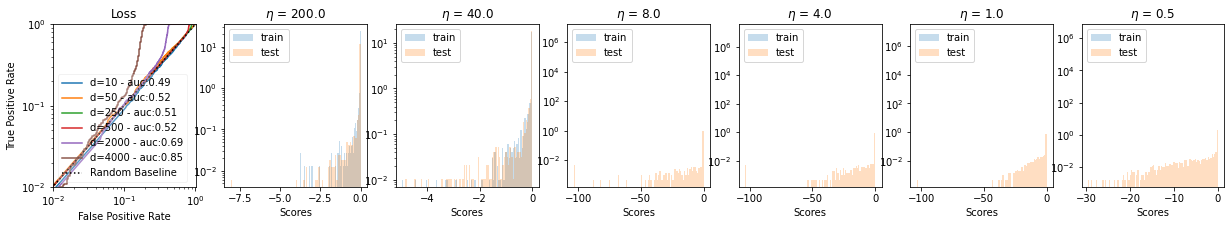

In [300]:
plots(scores['losses_train'], scores['losses_test'], synth_gauss['d'], title='Loss')

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


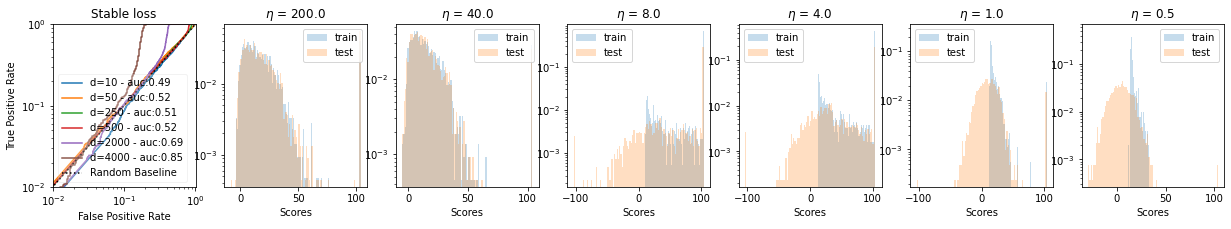

In [301]:
plots(scores['stable_losses_train'], scores['stable_losses_test'], synth_gauss['d'], title='Stable loss')

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


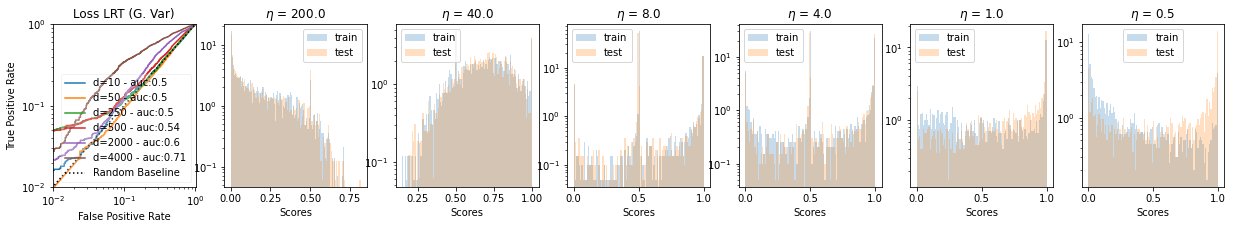

In [302]:
plots(scores['losses_lrt_train_global'], scores['losses_lrt_test_global'], synth_gauss['d'], title='Loss LRT (G. Var)', label=0)

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


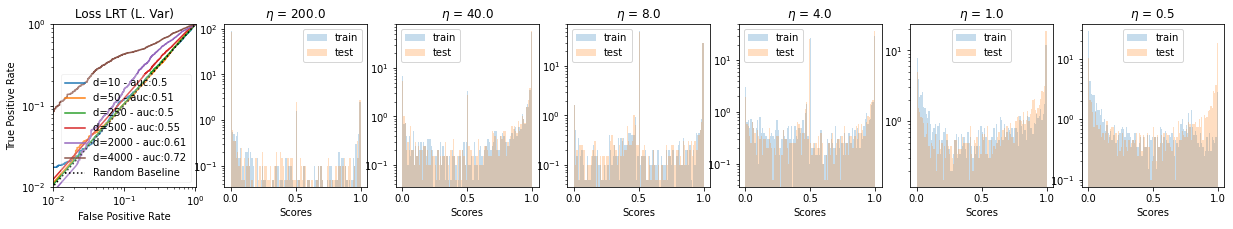

In [303]:
plots(scores['losses_lrt_train_local'], scores['losses_lrt_test_local'], synth_gauss['d'], title='Loss LRT (L. Var)', label=0)

### PREDICTIONS (NEW)

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


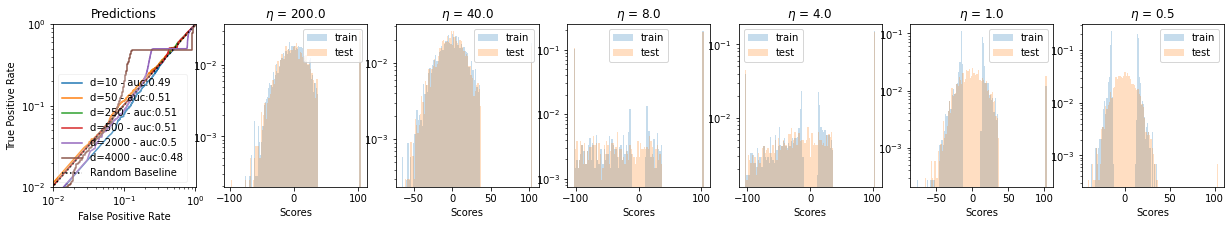

In [304]:
plots(scores['preds_train'], scores['preds_test'], synth_gauss['d'], title='Predictions')

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


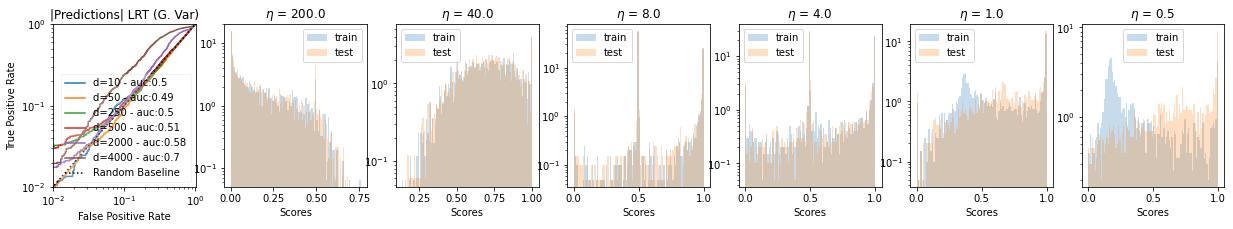

In [305]:
plots(scores['preds_lrt_train_global'], scores['preds_lrt_test_global'], synth_gauss['d'], title='|Predictions| LRT (G. Var)', label=0)

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


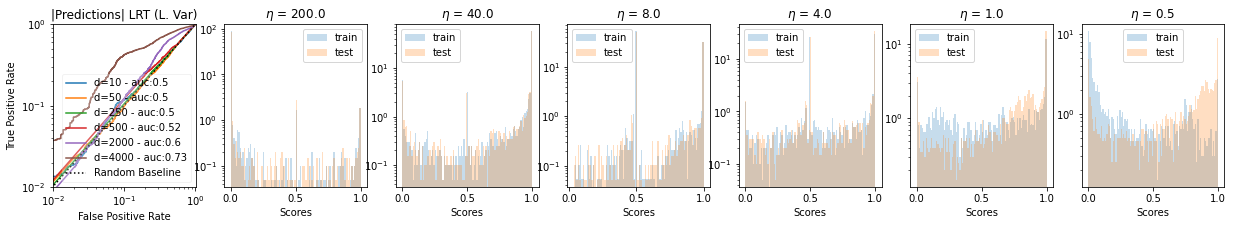

In [306]:
plots(scores['preds_lrt_train_local'], scores['preds_lrt_test_local'], synth_gauss['d'], title='|Predictions| LRT (L. Var)', label=0)

### DISTANCES (OUR's)

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


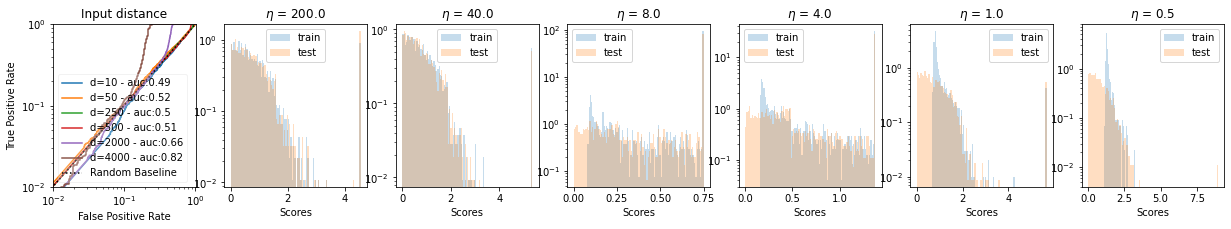

In [307]:
plots(scores['dists_train'], scores['dists_test'], synth_gauss['d'], title='Input distance')

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


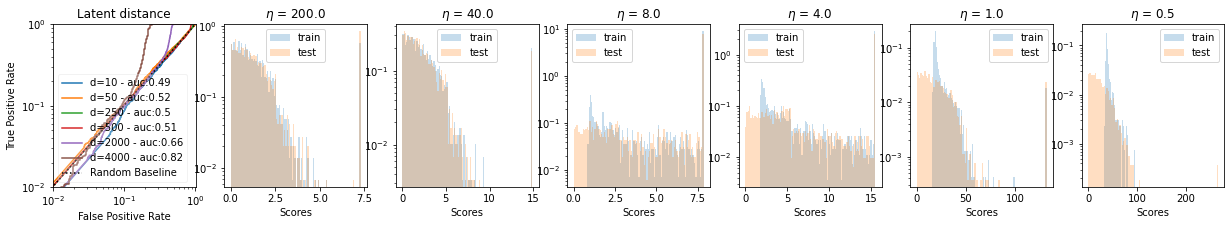

In [308]:
plots(scores['dists_latent_train'], scores['dists_latent_test'], synth_gauss['d'], title='Latent distance')

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


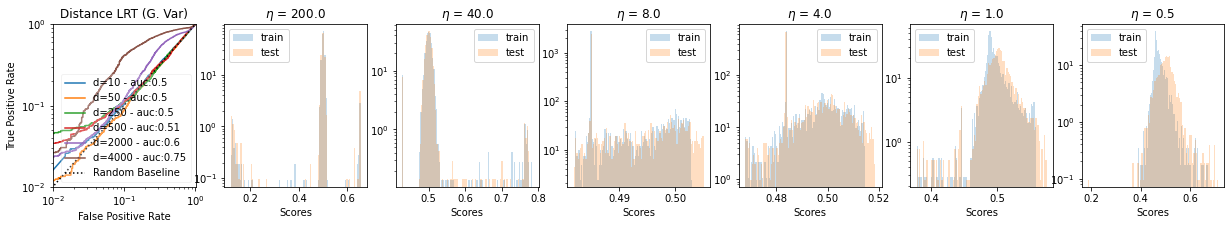

In [309]:
plots(scores['dists_lrt_train_global'], scores['dists_lrt_test_global'], synth_gauss['d'], title='Distance LRT (G. Var)', label=0)

(# train samples: 2000) / (dimension: 10) = eta: 200.0
(# train samples: 2000) / (dimension: 50) = eta: 40.0
(# train samples: 2000) / (dimension: 250) = eta: 8.0
(# train samples: 2000) / (dimension: 500) = eta: 4.0
(# train samples: 2000) / (dimension: 2000) = eta: 1.0
(# train samples: 2000) / (dimension: 4000) = eta: 0.5


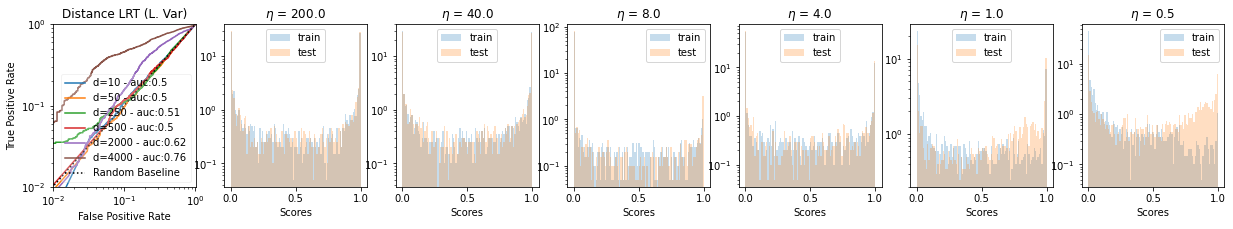

In [310]:
plots(scores['dists_lrt_train_local'], scores['dists_lrt_test_local'], synth_gauss['d'], title='Distance LRT (L. Var)', label=0)

### DISTANCES (NEW)

IndexError: list index out of range

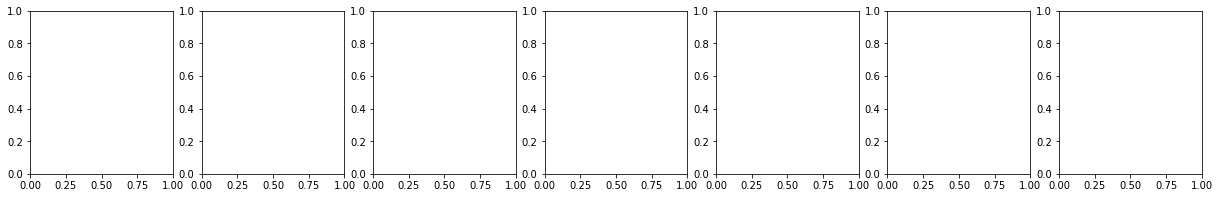

In [311]:
plots(scores['dists_train_quantile'], scores['dists_test_quantile'], synth_gauss['d'], title='Distance Quantile', label=1)